# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 09.11.2023

Мягкий дедлайн: 22.11.2023

Жесткий дедлайн: 26.11.2023

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 11

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного жёсткого дедлайна нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [346]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from IPython.display import clear_output
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [124]:
# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [125]:
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: Потому что y_random содержит вероятности того, что объекты принадлежать к положительному классу. В данном случае они все равны 1/2

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


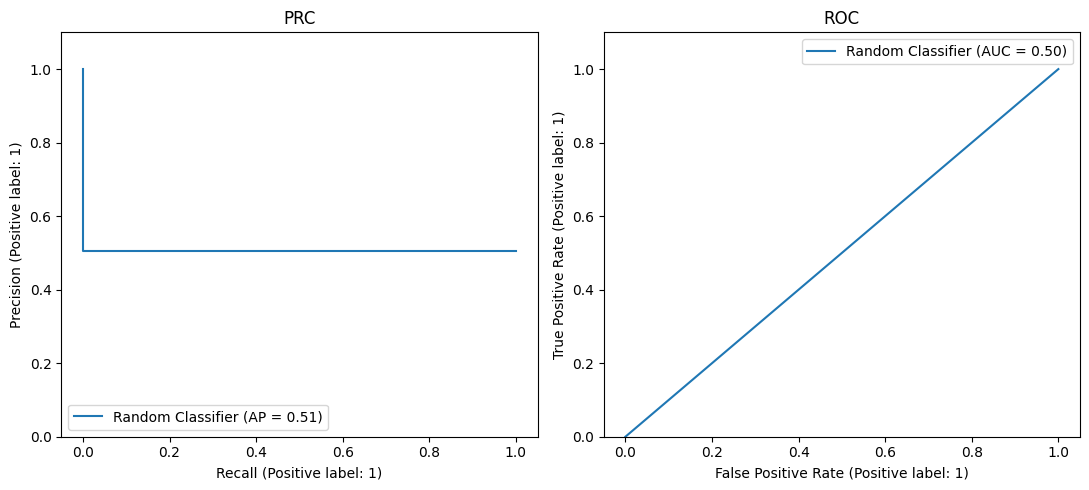

In [127]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [128]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [129]:
auc_pr_scorer = make_scorer(average_precision_score)
param_grid = {'C': np.logspace(0, 4, 10)}
model = LinearSVC(dual=True, max_iter=5000)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring=auc_pr_scorer)
grid_search.fit(X_train, y_train)
clear_output()

In [130]:
best_c_linsvc = grid_search.best_params_['C']
best_c_linsvc

2.7825594022071245

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

In [131]:
y_pred_linsvc = LinearSVC(dual=True, C=best_c_linsvc, max_iter=3000).fit(X_train, y_train).decision_function(X_test)

/home/boris/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


svm, LinearSVC metrics
AUC-PR: 0.82967
AUC-ROC: 0.84765


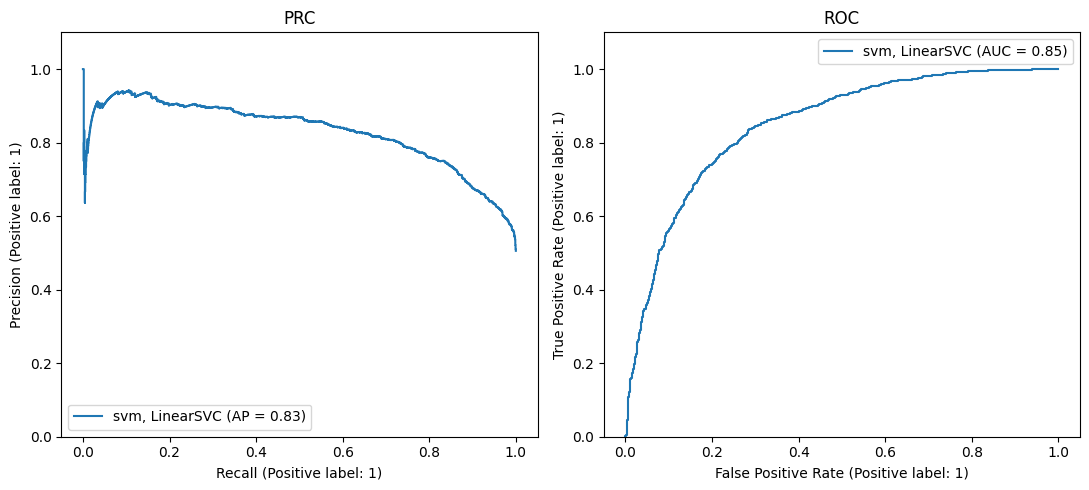

In [132]:
depict_pr_roc(y_test, y_pred_linsvc, 'svm, LinearSVC')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [133]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_linsvc)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['svm, LinearSVC'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_pred_linsvc),
      best_c_linsvc
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
"svm, LinearSVC",0.829672,0.847652,2.782559


**Ответ**: очевидно обе метрики выросли, а значит мы стали лучше предсказывать целевую переменную

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [134]:
model = LogisticRegression()

grid_search = GridSearchCV(model, param_grid, cv=5, scoring=auc_pr_scorer)
grid_search.fit(X_train, y_train)
clear_output()

In [135]:
best_c_logreg = grid_search.best_params_['C']
best_c_logreg

1.0

In [136]:
y_pred_logreg = LogisticRegression(C=best_c_logreg).fit(X_train, y_train).predict_proba(X_test)[:,1]

LogReg metrics
AUC-PR: 0.82912
AUC-ROC: 0.84787


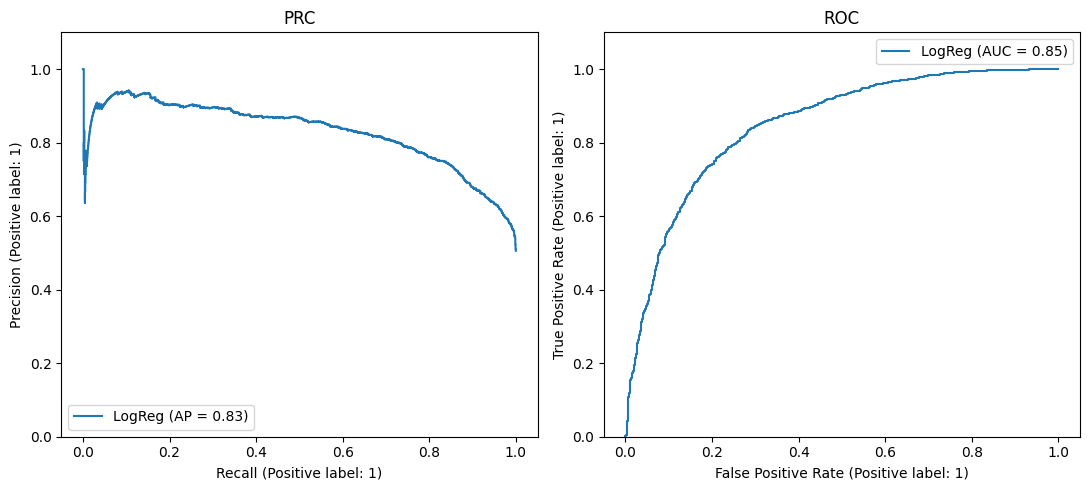

In [137]:
depict_pr_roc(y_test, y_pred_logreg, 'LogReg')

In [138]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_logreg)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['LogReg'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_pred_logreg),
      best_c_logreg
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.000000
"svm, LinearSVC",0.829672,0.847652,2.782559
LogReg,0.829115,0.847869,1.000000


Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000
svm, LinearSVC metrics
AUC-PR: 0.82967
AUC-ROC: 0.84765


LogReg metrics
AUC-PR: 0.82912
AUC-ROC: 0.84787


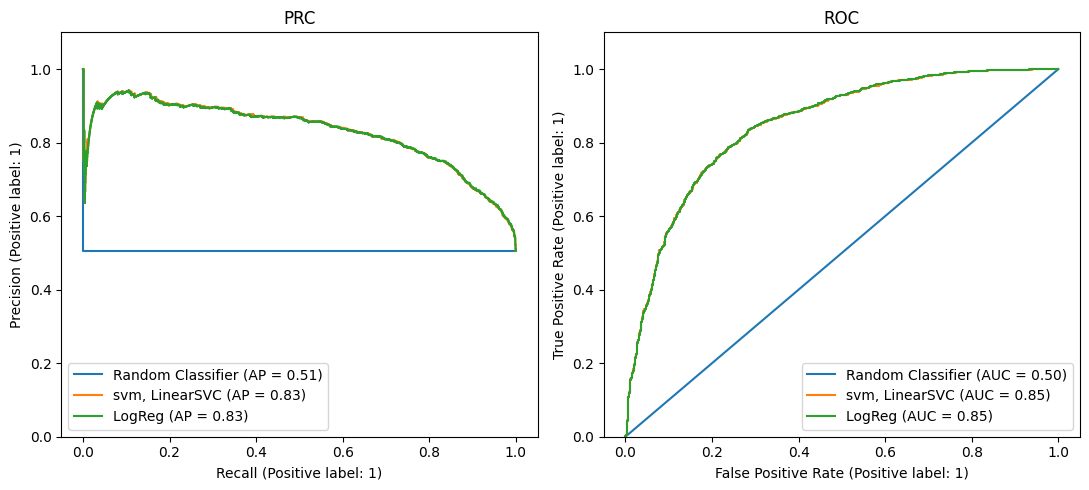

In [139]:
_, ax = plt.subplots(1, 2, figsize=(11, 5))

depict_pr_roc(y_test, y_random, 'Random Classifier', ax=ax)
depict_pr_roc(y_test, y_pred_linsvc, 'svm, LinearSVC', ax=ax)
depict_pr_roc(y_test, y_pred_logreg, 'LogReg', ax=ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** различий практически нет, оба метода справляются довольно хорошо.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [140]:
# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [141]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=best_c_linsvc)
model.fit(X_train, y_train)
clear_output()

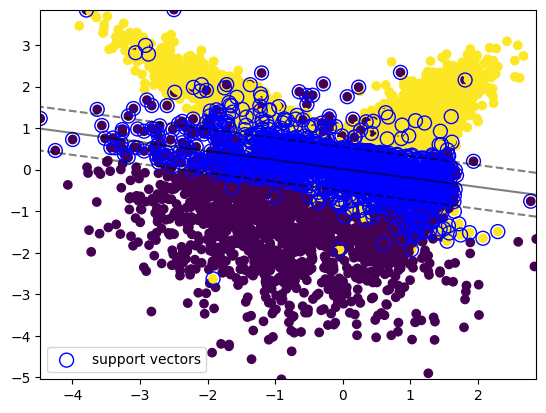

In [142]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y)

    #Отрисовали опорные векторы
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="blue",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X_train, y_train, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** опорными являются либо объекты близкие к получившейся гиперплоскости, либо те, которые на вражеской территории.

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [143]:
model = LogisticRegression(C=best_c_logreg)
model.fit(X_train, y_train)
clear_output()

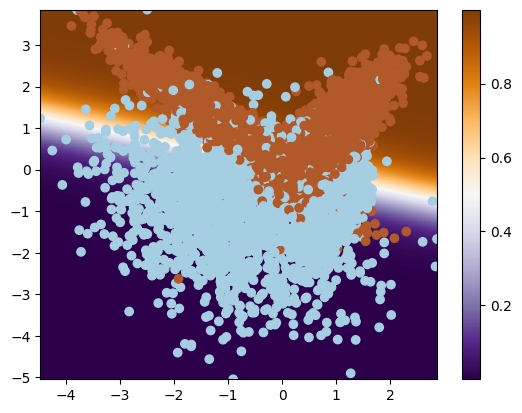

In [144]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 1000)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 1000)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:,1]
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y,
                cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X_train, y_train, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** Эта область является белой прямой. Это обосновывается тем, что в этой области наша модель не уверена в принятии решения, тк выдает вероятность около 0.5

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной кривой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [145]:
def plot_calibration_curve(y_test, preds, label):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.plot(bin_middle_points, bin_real_ratios, marker='o', label=label)

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [146]:
# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

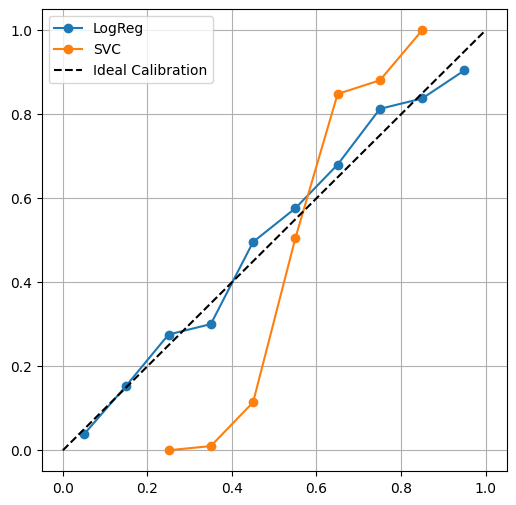

In [147]:
plt.figure(figsize=(6,6))

logreg = LogisticRegression(C=best_c_logreg)
logreg.fit(X_train, y_train)
plot_calibration_curve(y_test, logreg.predict_proba(X_test)[:, 1], 'LogReg')

svc = SVC(kernel='linear', C=best_c_linsvc, probability=True)
svc.fit(X_train, y_train)
plot_calibration_curve(y_test, (svc.decision_function(X_test) - np.min(X_test)) / (np.max(X_test) - np.min(X_test)) , 'SVC')

ideal_probs = np.linspace(0, 1, len(y_test))
plt.plot(ideal_probs, ideal_probs, linestyle='--', label='Ideal Calibration', color='black')
clear_output()
plt.ylim([-0.05, 1.05])
plt.grid()
plt.legend()
plt.show()


**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** Невооруженным глазом видно, что логистическая регрессия откалибрована лучше, чем метод опорных векторов

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

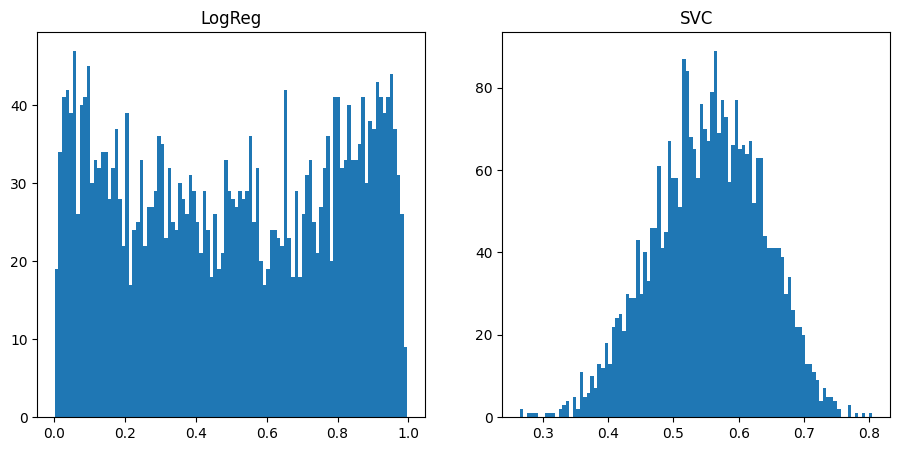

In [148]:
_, ax = plt.subplots(1, 2, figsize=(11, 5))

ax[0].hist(logreg.predict_proba(X_test)[:, 1], bins=100)
ax[0].set_title("LogReg")
ax[1].hist((svc.decision_function(X_test) - np.min(X_test)) / (np.max(X_test) - np.min(X_test)), bins=100)
ax[1].set_title("SVC")
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** у метода опорных векторов большая часть вероятностей лежит около 0.5. Это в очередной раз говорит о том, что svc плохо предсказывает вероятность ответа. У логистической же регрессии ответы распределены более равномерно. Я могу это объяснить двумя фактами:

1. логистическая регрессия это метод мактимального правдоподобия для распределения Бернулли. Как следствие она выдает нам правдивые вероятности.

2. svc никак не заточен на предсказание интерпретируемых вероятностей. Он заточен на максимизацию расстояние между классами.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

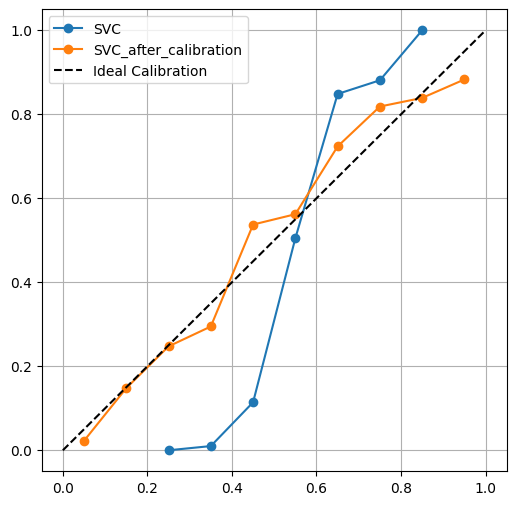

In [149]:
plt.figure(figsize=(6,6))

svc = SVC(kernel='linear', C=best_c_linsvc, probability=True)
svc.fit(X_train, y_train)
plot_calibration_curve(y_test, (svc.decision_function(X_test) - np.min(X_test)) / (np.max(X_test) - np.min(X_test)) , 'SVC')

calibrated_svm_model = CalibratedClassifierCV(estimator=svc, method='sigmoid')
calibrated_svm_model.fit(X_train, y_train)
plot_calibration_curve(y_test, svc.predict_proba(X_test)[:, 1], 'SVC_after_calibration')

ideal_probs = np.linspace(0, 1, len(y_test))
plt.plot(ideal_probs, ideal_probs, linestyle='--', label='Ideal Calibration', color='black')
clear_output()
plt.ylim([-0.05, 1.05])
plt.grid()
plt.legend()
plt.show()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** стало сильно лучше. Калибровочная прямая теперь очень похожа на калибровочную прямую логистической регрессии.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [150]:
# по сути тут нужно применить логистическую регрессию без регуляризации к выходам svc

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

(бесценный шаг)

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [347]:
df = pd.read_csv('bike_buyers.csv')
# уберем столбец ID, тк от него явно не зависит целевая переменная
df.drop('ID', axis=1, inplace=True)

X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

#Разделим на категориальные признаки и числовые
X_numerical = df[list(X.select_dtypes([np.number]).columns)].fillna(0)
X_categorical = df[list(X.dtypes[X.dtypes == "object"].index)].fillna('undefined')


В начале поработаем только с категориальными признаками

In [348]:
X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [349]:
start = time.time()
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

logreg_model = LogisticRegression()
logreg_model.fit(X_train_encoded, y_train)

print("Time spent: ", time.time() - start)

precision, recall, _ = precision_recall_curve(y_test, logreg_model.predict_proba(X_test_encoded)[:,1])
print('AUC-PR: %.5f' % auc(recall, precision))

Time spent:  0.06974077224731445
AUC-PR: 0.57894


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [350]:
start = time.time()
encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

logreg_model = LogisticRegression()
logreg_model.fit(X_train_encoded, y_train)

print("Time spent: ", time.time() - start)

precision, recall, _ = precision_recall_curve(y_test, logreg_model.predict_proba(X_test_encoded)[:,1])
print('AUC-PR: %.5f' % auc(recall, precision))

Time spent:  0.041242122650146484
AUC-PR: 0.66186


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [351]:
start = time.time()

X_train_num = X_train.copy()
X_test_num = X_test.copy()

train_encoded = pd.concat([X_train_num, y_train], axis=1)

for col in X_train_num.columns:
    means = train_encoded.groupby(col)['Purchased Bike'].mean()

    X_train_num[col] = X_train_num[col].map(means)
    X_test_num[col] = X_test_num[col].map(means)

X_train_num = X_train_num.astype('float64')
X_test_num = X_test_num.astype('float64')

logreg_model = LogisticRegression()
logreg_model.fit(X_train_num, y_train)

print("Time spent: ", time.time() - start)

precision, recall, _ = precision_recall_curve(y_test, logreg_model.predict_proba(X_test_num)[:,1])
print('AUC-PR: %.5f' % auc(recall, precision))

Time spent:  0.03997969627380371
AUC-PR: 0.65269


Учиться быстрее и занимает меньше места в памяти, но качество слегка ухудшилось. Работаем дальше.

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [352]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetTransformer(BaseEstimator, TransformerMixin):
   def __init__(self, cat_features, noise: float | None = None) -> None:
      self.cat_features = cat_features
      self.noise = noise
      self.new_values = dict()

   def fit(self, X_train, y_train) -> 'MeanTargetTransformer':
      train_encoded = pd.concat([X_train, y_train], axis=1)

      for col in self.cat_features:
         self.new_values[col] = train_encoded.groupby(col)['Purchased Bike'].mean()

      return self
        
   def transform(self, data, y_data = None) -> pd.DataFrame:
      data_num = data.copy()

      for col in self.cat_features:
         data_num[col] = data_num[col].map(self.new_values[col])

      if self.noise is not None:
         data_num[col] += np.random.normal(0, self.noise, data_num[col].shape)
            
      data_num = data_num.astype('float64')

      return data_num
                

In [353]:
start = time.time()

mt_trans = MeanTargetTransformer(X_train.columns)
X_train_num_trans = mt_trans.fit_transform(X_train, y_train)
X_test_num_trans = mt_trans.transform(X_test)

logreg_model = LogisticRegression()
logreg_model.fit(X_train_num_trans, y_train)

print("Time spent: ", time.time() - start)

precision, recall, _ = precision_recall_curve(y_test, logreg_model.predict_proba(X_test_num_trans)[:,1])
print('AUC-PR: %.5f' % auc(recall, precision))

Time spent:  0.026648521423339844
AUC-PR: 0.65269


Получили идентичное качество.

_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

Попробуем добавить нормального шума:

In [371]:
start = time.time()

mt_trans = MeanTargetTransformer(X_train.columns, noise=200)
X_train_num_noise = mt_trans.fit_transform(X_train, y_train)
X_test_num_noise = mt_trans.transform(X_test)

logreg_model = LogisticRegression()
logreg_model.fit(X_train_num_noise, y_train)

print("Time spent: ", time.time() - start)

precision, recall, _ = precision_recall_curve(y_test, logreg_model.predict_proba(X_test_num_noise)[:, 1])
print('AUC-PR: %.5f' % auc(recall, precision))

Time spent:  0.02996659278869629
AUC-PR: 0.65380


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** Добавление шума практически не улучшило качество, хотя он способствует регуляризации. А она необходима, так как мы начали опираться на значения целевой переменной, чего делать нельзя.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [372]:
# тут что-то показалось что заморочиться надо. Идеи вроде понятные, но за 5 минут простая реализация в голову не пришла

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [373]:
class GlobalMeanTransformer(BaseEstimator, TransformerMixin):
   def __init__(self, cat_features,*, C: float = 10) -> None:
      self.cat_features = cat_features
      self.C = C
      self.new_values = dict()

   def fit(self, X_train, y_train) -> 'MeanTargetTransformer':
      train_encoded = pd.concat([X_train, y_train], axis=1)

      for col in self.cat_features:
         self.new_values[col] = ((train_encoded.groupby(col)['Purchased Bike'].sum() + self.C * np.mean(y_train)) / 
                                                      (train_encoded.groupby(col)['Purchased Bike'].size() + self.C))

      return self
        
   def transform(self, data, y_data = None) -> pd.DataFrame:
      data_num = data.copy()

      for col in self.cat_features:
         data_num[col] = data_num[col].map(self.new_values[col])

            
      data_num = data_num.astype('float64')

      return data_num
                

In [374]:
start = time.time()

mt_trans = GlobalMeanTransformer(X_train.columns, C=5)
X_train_num_trans = mt_trans.fit_transform(X_train, y_train)
X_test_num_trans = mt_trans.transform(X_test)

logreg_model = LogisticRegression()
logreg_model.fit(X_train_num_trans, y_train)

print("Time spent: ", time.time() - start)

precision, recall, _ = precision_recall_curve(y_test, logreg_model.predict_proba(X_test_num_trans)[:,1])
print('AUC-PR: %.5f' % auc(recall, precision))

Time spent:  0.040612220764160156
AUC-PR: 0.66864


Качество ohe = 0.66186

Мы получили при использовании global_mean = 0.66864

Победа!

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к признакам-счетчикам.


В данных есть пропуски - замените их средним значением признака



In [375]:
X_train, X_test, y_train, y_test = train_test_split(pd.concat((X_categorical, X_numerical), axis=1), y, test_size=0.25, random_state=777, stratify=y)

 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков (вместе и по отдельности). Стало ли лучше?

Понятно, что у всех числовых признаков разное количество уникальных значений. Посмотрим сколько в каждом признаке.

In [376]:
X_train.dtypes

Marital Status       object
Gender               object
Education            object
Occupation           object
Home Owner           object
Commute Distance     object
Region               object
Income              float64
Children            float64
Cars                float64
Age                 float64
dtype: object

In [377]:
X_train['Income'].value_counts().size, X_train['Children'].value_counts().size, X_train['Cars'].value_counts().size, X_train['Age'].value_counts().size

(17, 6, 5, 54)

Попробуем обучить не применяя счетчики к числовым признакам, чтобы получить бейзлайн.

In [378]:
def print_time_and_auc_pr(features_to_encode: list[str] = []) -> None:
    start = time.time()

    mt_trans = MeanTargetTransformer(features_to_encode)
    X_train_num_trans = mt_trans.fit_transform(X_train, y_train)
    X_test_num_trans = mt_trans.transform(X_test)

    logreg_model = LogisticRegression(max_iter=5000)
    logreg_model.fit(X_train_num_trans, y_train)

    print("Time spent: ", time.time() - start)

    precision, recall, _ = precision_recall_curve(y_test, logreg_model.predict_proba(X_test_num_trans)[:,1])
    print('AUC-PR: %.5f' % auc(recall, precision))

In [379]:
print_time_and_auc_pr(X_categorical.columns)

Time spent:  0.019808053970336914
AUC-PR: 0.43720


Для начала будем по отдельности заменять числовые признаки счетчиками. В силу того, что на чисто категориальных признаках лучше всего показал себя mean-target encoder с шумом, дальше будем пользоваться им.

In [380]:
print('with Income')
print_time_and_auc_pr(list(X_categorical.columns) + ['Income'])
print('with Children')
print_time_and_auc_pr(list(X_categorical.columns) + ['Children'])
print('with Cars')
print_time_and_auc_pr(list(X_categorical.columns) + ['Cars'])
print('with Age')
print_time_and_auc_pr(list(X_categorical.columns) + ['Age'])

with Income
Time spent:  0.04186248779296875
AUC-PR: 0.69341
with Children
Time spent:  0.014797210693359375
AUC-PR: 0.43721
with Cars
Time spent:  0.019764423370361328
AUC-PR: 0.43720
with Age
Time spent:  0.015505790710449219
AUC-PR: 0.45383


Тепеть закодируем счетчиками все признаки сразу

In [381]:
print('all features')
print_time_and_auc_pr(X_train.columns)

all features
Time spent:  0.029526948928833008
AUC-PR: 0.66310


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 

Плюсы: 

1. Перестаем тратить кучу памяти на новые признаки, которые появляются при ohe

2. Качество улучшается, порой оно достигает даже лучшего качества, чем при применении ohe

Минусы:


1. Берем информацию из целевой переменной. Хоть мы и хотим это как можно лучше спрятать - факт остается фактом. А это влечет за собой переобучение.

# Часть 3. Отбор признаков (2 балла)

#### Подготовка данных

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [9]:
!wget --no-check-certificate https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2023-11-14 18:17:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 

128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data.1’

adult.data.1            [      <=>           ]   1,23M  1005KB/s               ^C


In [382]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
           'education-num', 'marital-status', 'occupation',
           'relationship', 'race', 'sex', 'capital-gain',
           'capital-loss', 'hours-per-week', 'native-country',
           'income']

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
9640,33,Private,276221,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`.

In [383]:
X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [384]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24420, 14), (24420,), (8141, 14), (8141,))

In [385]:
def get_ohe(ohe, X, features: list[str], fit: bool) -> pd.DataFrame:
    if fit:
        encoded_features = ohe.fit_transform(X[features])
    else:
        encoded_features = ohe.transform(X[features])
    encoded_data = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(input_features=features), index=X.index)
    res = pd.concat([X, encoded_data], axis=1)
    res.drop(features, axis=1, inplace=True)
    return res

In [386]:
numeric = list(X_train.select_dtypes([np.number]).columns)
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)

ohe = OneHotEncoder(sparse_output=False)
print('before ohe shape = ', X_train[categorical].shape)
X_train_cat_ohe = get_ohe(ohe, X_train, categorical, True)
X_test_cat_ohe = get_ohe(ohe, X_test, categorical, False)
print('after ohe shape = ', X_train_cat_ohe.shape)

X_train_ohe = pd.concat([X_train[numeric], X_train_cat_ohe], axis=1)
X_test_ohe = pd.concat([X_test[numeric], X_test_cat_ohe], axis=1)

before ohe shape =  (24420, 8)
after ohe shape =  (24420, 108)


Мы получили 108 - 8 = 100 новых пизнаков

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [387]:
start = time.time()

logreg_model = LogisticRegression(max_iter=4000)
logreg_model.fit(X_train_ohe, y_train)

print("Time spent: ", time.time() - start)

precision, recall, _ = precision_recall_curve(y_test, logreg_model.predict_proba(X_test_ohe)[:,1])
print('AUC-PR: %.5f' % auc(recall, precision))

Time spent:  0.5984411239624023
AUC-PR: 0.45038


#### __Задание 9. Встроенные методы (0.5 балла)__

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [298]:
start = time.time()

weights = logreg_model.coef_[0]
top_features_indices = np.argsort(np.abs(weights))[::-1][:40]
X_train_40 = X_train_ohe.iloc[:, top_features_indices]
X_test_40 = X_test_ohe.iloc[:, top_features_indices]

logreg_model = LogisticRegression(max_iter=4000)
logreg_model.fit(X_train_40, y_train)

print("Time spent: ", time.time() - start)

precision, recall, _ = precision_recall_curve(y_test, logreg_model.predict_proba(X_test_40)[:,1])
print('AUC-PR: %.5f' % auc(recall, precision))

Time spent:  14.108965635299683
AUC-PR: 0.75669


Изменилось ли качество? Как?

**Ответ:** Качество улучшелось аж на 0.3! Видимо остальные признаки только создавали лишний шум.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [299]:
X_num_train = X_train.select_dtypes(include=[np.number])
X_num_test = X_test.select_dtypes(include=[np.number])

ss = StandardScaler()

X_num_train_scaled = pd.DataFrame(ss.fit_transform(X_num_train), columns=X_num_train.columns, index=X_num_train.index)
X_num_test_scaled = pd.DataFrame(ss.transform(X_num_test), columns=X_num_train.columns, index=X_num_test.index)

X_cat_train = X_train.select_dtypes(include=['object'])
X_cat_test = X_test.select_dtypes(include=['object'])

X_train_scaled = pd.concat([X_num_train_scaled, X_cat_train], axis=1)
X_test_scaled = pd.concat([X_num_test_scaled, X_cat_test], axis=1)


In [300]:
X_train_scaled.shape, X_train.shape, X_num_train.shape, X_cat_train.shape

((24420, 14), (24420, 14), (24420, 6), (24420, 8))

In [301]:
# используем все признаки

ohe = OneHotEncoder(sparse_output=False)
X_train_cat_ohe = get_ohe(ohe, X_train_scaled, categorical, True)
X_test_cat_ohe = get_ohe(ohe, X_test_scaled, categorical, False)

X_train_scaled_ohe = pd.concat([X_train_scaled[numeric], X_train_cat_ohe], axis=1)
X_test_scaled_ohe = pd.concat([X_test_scaled[numeric], X_test_cat_ohe], axis=1)

In [302]:
start = time.time()

logreg_model = LogisticRegression(max_iter=3000)
logreg_model.fit(X_train_scaled_ohe, y_train)

print("Time spent: ", time.time() - start)

precision, recall, _ = precision_recall_curve(y_test, logreg_model.predict_proba(X_test_scaled_ohe)[:,1])
print('AUC-PR: %.5f' % auc(recall, precision))

Time spent:  4.887979984283447
AUC-PR: 0.76714


In [303]:
# 40 лучших

weights = logreg_model.coef_[0]
top_features_indices = np.argsort(np.abs(weights))[::-1][:40]
X_train_40 = X_train_scaled_ohe.iloc[:, top_features_indices]
X_test_40 = X_test_scaled_ohe.iloc[:, top_features_indices]

In [304]:
start = time.time()

logreg_model = LogisticRegression(max_iter=3000)
logreg_model.fit(X_train_40, y_train)

print("Time spent: ", time.time() - start)

precision, recall, _ = precision_recall_curve(y_test, logreg_model.predict_proba(X_test_40)[:,1])
print('AUC-PR: %.5f' % auc(recall, precision))

Time spent:  1.0188262462615967
AUC-PR: 0.70635


**Ответ:** Если использовать все признаки, то при масштабировании получилось лучше. А вот если оставить только 40 наибольших по модули, то похуже.

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [305]:
ss = StandardScaler()

X_train_scaled_ohe_full = pd.DataFrame(ss.fit_transform(X_train_ohe), columns=X_train_ohe.columns, index=X_train_ohe.index)
X_test_scaled_ohe_full = pd.DataFrame(ss.transform(X_test_ohe), columns=X_train_ohe.columns, index=X_test_ohe.index)

In [306]:
start = time.time()

logreg_model = LogisticRegression(max_iter=3000)
logreg_model.fit(X_train_scaled_ohe_full, y_train)

print("Time spent: ", time.time() - start)

precision, recall, _ = precision_recall_curve(y_test, logreg_model.predict_proba(X_test_scaled_ohe_full)[:,1])
print('AUC-PR: %.5f' % auc(recall, precision))

Time spent:  0.9207260608673096
AUC-PR: 0.76611


In [307]:
weights = logreg_model.coef_[0]
top_features_indices = np.argsort(np.abs(weights))[::-1][:40]
X_train_40 = X_train_scaled_ohe_full.iloc[:, top_features_indices]
X_test_40 = X_test_scaled_ohe_full.iloc[:, top_features_indices]

In [308]:
start = time.time()

logreg_model = LogisticRegression(max_iter=3000)
logreg_model.fit(X_train_40, y_train)

print("Time spent: ", time.time() - start)

precision, recall, _ = precision_recall_curve(y_test, logreg_model.predict_proba(X_test_40)[:,1])
print('AUC-PR: %.5f' % auc(recall, precision))

Time spent:  1.0634841918945312
AUC-PR: 0.76084


**Ответ:** получился необычный результат. На всех признаках качество ухудшилось, а в случае когда мы выбираем 40 лучших признаков улучшилось. Мне кажется, что скейлить категориальные признаки не самая лучшая идея, потому что в процессе мы вычитаем среднее ($\frac{1}{p}$) и делим на корень из дисперсии ($p(1 - p)$). Проблемы могут возникнуть, когда мы начнем вычитать из 0 $\frac{1}{p}$. Вылезут очень большие числа.

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.



In [309]:
def calc_t(feature_col, y) -> float:
    n_plus = np.sum(y == 1)
    n_minus = np.sum(y == 0)
    numerator = np.abs(np.mean(feature_col[y == 1]) - np.mean(feature_col[y == 0]))

    sigma_plus = np.mean((feature_col[y == 1] - np.mean(feature_col[y == 1])) ** 2)
    sigma_minus = np.mean((feature_col[y == 0] - np.mean(feature_col[y == 0])) ** 2)
    denominator = np.sqrt((n_plus * sigma_plus + n_minus * sigma_minus) / (n_plus + n_minus))

    return numerator / denominator

In [310]:
start = time.time()

t_stats = [calc_t(X_train_scaled_ohe.iloc[:,i], y_train) for i in range(X_train_scaled_ohe.shape[1])]
top_features_indices = np.argsort(np.abs(t_stats))[::-1][:40]
X_train_40 = X_train_scaled_ohe.iloc[:, top_features_indices]
X_test_40 = X_test_scaled_ohe.iloc[:, top_features_indices]

logreg_model = LogisticRegression(max_iter=4000)
logreg_model.fit(X_train_40, y_train)

print("Time spent: ", time.time() - start)

precision, recall, _ = precision_recall_curve(y_test, logreg_model.predict_proba(X_test_40)[:,1])
print('AUC-PR: %.5f' % auc(recall, precision))

Time spent:  1.1946756839752197
AUC-PR: 0.75802


Качество получилось примерно такое же, как и раньше, а вот сошелся алгоритм быстрее.

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, на каждом шаге мы будем удалять такой признак $j$, что качество модели на множестве оставшихся признаков без $j$ максимально, то есть удалять мы будем наиболее бесполезный признак.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [311]:
X_train_small, X_val, y_train, y_val = train_test_split(X_train_scaled_ohe, y_train, test_size=0.25, random_state=777)

In [327]:
def get_auc_pr(X_train, X_test, y_train, y_test, col: str | None = None) -> float:
    lr = LogisticRegression(max_iter=3000)
    if col is not None:
        lr.fit(X_train.drop(col, axis=1), y_train)
        precision, recall, _ = precision_recall_curve(y_test, lr.predict_proba(X_test.drop(col, axis=1))[:, 1])
    else:
        lr.fit(X_train, y_train)
        precision, recall, _ = precision_recall_curve(y_test, lr.predict_proba(X_test)[:, 1])
    score = auc(recall, precision)
    return score

def delete_feature(X_train, X_test, y_train, y_test) -> float:
    scores = dict()
    for col in list(X_train.columns.values):
        score = get_auc_pr(X_train, X_test, y_train, y_test, col)
        scores[score] = col
    sorted_scores = {v: k for k, v in sorted(scores.items(), key=lambda item: item[0], reverse=True)}
    bad_col = next(iter(sorted_scores))
    X_train.drop(bad_col, axis=1, inplace=True)
    X_test.drop(bad_col, axis=1, inplace=True)
    return sorted_scores[bad_col]

def delete_features(X_train_small, X_val, y_train, y_val, tolerance: float = 1e-6) -> list[float]:
    auc_pr_history = []
    auc_pr_history.append(get_auc_pr(X_train_small, X_val, y_train, y_val))
    while X_train_small.shape[1] > 40:
        auc_pr_history.append(delete_feature(X_train_small, X_val, y_train, y_val))

        if np.abs(auc_pr_history[-1] - auc_pr_history[-2]) < tolerance:
            break

    return auc_pr_history

In [329]:
auc_history = delete_features(X_train_small, X_val, y_train, y_val)

In [330]:
len(auc_history), auc_history[-1]

(10, 0.7574928570221312)

**Ответ:** Работа алгоритма заняла 28 минут. Спасибо vscode, который помог мне в логировании этого значения

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [342]:
def add_feature(X_train, X_val, y_train, y_val, current_features, not_used_features):
    best_score = -1
    best_feature = None

    for col in not_used_features:
        current_features.append(col)
        score = get_auc_pr(X_train[current_features], X_val[current_features], y_train, y_val)
        current_features.remove(col)

        if score > best_score:
            best_score = score
            best_feature = col

    return best_feature, best_score

def add_features(X_train_small, X_val, y_train, y_val, target_num_features: int = 40):
    current_features = []
    auc_pr_history = []
    not_used_features = list(X_train_small.columns.values)
    auc_pr_history.append(0)

    while len(current_features) < target_num_features:
        new_feature, score = add_feature(X_train_small, X_val, y_train, y_val, current_features, not_used_features)

        if new_feature is not None:
            current_features.append(new_feature)
            not_used_features.remove(new_feature)
            auc_pr_history.append(score)
        else:
            break

    return auc_pr_history, current_features

In [ ]:
auc_history, added_features = add_features(X_train_small, X_val, y_train, y_val)

In [345]:
len(auc_history), auc_history[-1]

(41, 0.7577159237206732)

Работа алгоритма заняла всего 13 минут. Это более чем в 2 раза меньше, чем при удалении признаков.

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:**

Глобально лучший результат получился, когда мы поскейлили наши признаки и оставили их все, что в очередной раз подтверждает, что чем больше данных - тем лучше.

AUC-PR: 0.76714 - просто скейлим числовые и ohe на категориальные

Теперь посмотрим на то, что получилось в методах уменьшения количества признаков, которые мы рассматривали:

Встроенные методы:

1. AUC-PR: 0.76084 - довольно не плохой результат. Как видим дальше, при помощи этого метода удалось получить наилучшее качество.

Методы фильтрации:

1. AUC-PR: 0.75802

2. Плюс: получаем статистически значимые признаки в модели.

3. Минус: получаем качество хуже, чем при использовании встроенных методов.

Методы обертки:

1. AUC-PR: 0.75771

2. Чертовски долго работает и не дает буста в качестве. Юзлесс метод.


# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [123]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2023-11-16 09:20:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 

128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip’

bank-additional.zip     [     <=>            ] 434,15K   531KB/s    in 0,8s    

2023-11-16 09:20:50 (531 KB/s) - ‘bank-additional.zip’ saved [444572]

Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [228]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [229]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки.

In [230]:
kf = KFold(n_splits=5, shuffle=True, random_state=500)

Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков и `StandardScaler` для числовых, гиперпараметры по умолчанию) и сделайте предсказания для соответствующих тестовых выборок.

In [231]:
def train_with_LR(x_train: pd.DataFrame, x_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame, *, C: int = 1) -> LogisticRegression:
    numeric_features = x_train.select_dtypes([np.number]).columns
    categorical = list(x_train.dtypes[x_train.dtypes == "object"].index)

    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
        ('scaling', StandardScaler(), numeric_features)
    ])

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LogisticRegression(C=C, max_iter=3000))
    ])

    model = pipeline.fit(x_train, y_train)
    precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(x_test)[:,1])

    return recall, precision
    

In [232]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    recall, precision = train_with_LR(X_train, X_test, y_train, y_test)
    
    print('AUC-PR: %.5f' % auc(recall, precision))

AUC-PR: 0.48013
AUC-PR: 0.43777
AUC-PR: 0.45010
AUC-PR: 0.46033
AUC-PR: 0.43091


Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Также вычислите стандартное отклонение.
- Сколько денег вы в среднем заработаете?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [233]:
def calc_revenue_and_calls(x_train, x_test, y_train, y_test, random, C) -> list[float]:
    numeric_features = x_train.select_dtypes([np.number]).columns
    categorical = list(x_train.dtypes[x_train.dtypes == "object"].index)

    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
        ('scaling', StandardScaler(), numeric_features)
    ])

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LogisticRegression(C=C, max_iter=1000))
    ])

    model = pipeline.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    calls = np.sum(y_pred)
    if random:
        revenue = np.sum((y_buyers := y_pred[y_test == 1]) * np.random.uniform(0, 20, len(y_buyers)))
    else:
        revenue = np.sum((y_buyers := y_pred[y_test == 1]) * 10)

    return revenue, calls

def calc_rev_calls_income_std(kf, random: bool, *, C: float = 1) -> list[float]:
    revenues = []
    num_of_calls = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        revenue, calls = calc_revenue_and_calls(X_train, X_test, y_train, y_test, random, C)
        revenues.append(revenue)
        num_of_calls.append(calls)

    mean_income = np.mean(revenues) - np.mean(num_of_calls)
    incomes = np.array(revenues) - np.array(num_of_calls)
    income_std = sum([(income - mean_income) ** 2 for income in incomes]) / len(incomes)

    return revenues, num_of_calls, income_std

In [234]:
revenues, num_of_calls, income_std = calc_rev_calls_income_std(kf, False)

print(f'В среднем заработаем: {np.mean(revenues)} баксов')
print(f'при этом придется отдать сотрудникам {np.mean(num_of_calls)} баксов')
print(f'стандартное отклонение выручки от стреднего равно {"{:.2f}".format(np.sqrt(income_std))}')

В среднем заработаем: 2130.0 баксов
при этом придется отдать сотрудникам 324.2 баксов
стандартное отклонение выручки от стреднего равно 108.68


**Ответ:** В среднем я заработаю 2130 баксов, но 324 из них мне придется отдать операторам.

Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [235]:
revenues, num_of_calls, income_std = calc_rev_calls_income_std(kf, True)

print(f'В среднем заработаем: {"{:.2f}".format(np.mean(revenues))} баксов')
print(f'при этом придется отдать сотрудникам {np.mean(num_of_calls)} баксов')
print(f'стандартное отклонение выручки от стреднего равно {"{:.2f}".format(np.sqrt(income_std))}')

В среднем заработаем: 2162.67 баксов
при этом придется отдать сотрудникам 324.2 баксов
стандартное отклонение выручки от стреднего равно 85.01


**Ответ:** Получилось что я смогу заработать больше - 2162 бакса.

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, укажите стандартные отклонения (вам поможет `plt.errorbar`, [пример](https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html)).

In [236]:
def calc_mean_income_and_std(kf, C, threshold: float = 0.5):
    revenues, num_of_calls, income_std = calc_rev_calls_income_std(kf, True, C=C, threshold=threshold)
    mean_income = np.mean(revenues) - np.mean(num_of_calls)
    return mean_income, income_std

In [206]:
Cs = np.logspace(-3, 3, 7)
scores = dict()
mean_incomes = []
stds = []
for C in Cs:
    mean_income, income_std = calc_mean_income_and_std(kf, C)
    mean_incomes.append(mean_income)
    stds.append(income_std)
    scores[mean_income] = C

best_c = next(iter({v: k for k, v in sorted(scores.items(), key=lambda item: item[0], reverse=True)}))


In [207]:
best_c

1000.0

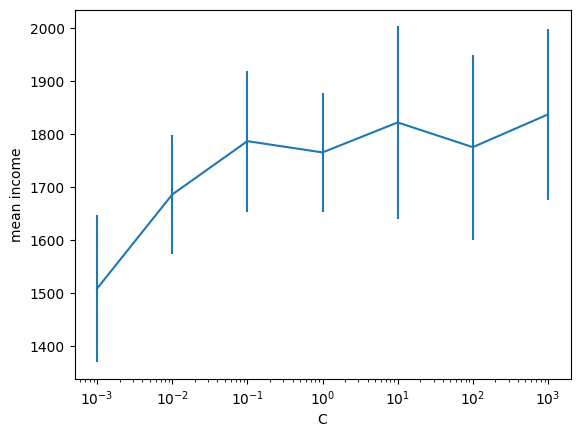

In [208]:
plt.errorbar(x=Cs, y=mean_incomes, yerr=np.sqrt(stds))
plt.xscale('log')
plt.ylabel('mean income')
plt.xlabel('C')
plt.show()

In [209]:
revenues, num_of_calls, income_std = calc_rev_calls_income_std(kf, True, C=best_c)

print(f'В среднем заработаем: {"{:.2f}".format(np.mean(revenues))} баксов')
print(f'при этом придется отдать сотрудникам {np.mean(num_of_calls)} баксов')
print(f'стандартное отклонение выручки от стреднего равно {"{:.2f}".format(np.sqrt(income_std))}')

В среднем заработаем: 2109.92 баксов
при этом придется отдать сотрудникам 324.4 баксов
стандартное отклонение выручки от стреднего равно 120.75


**Ответ:** Мне кажется не лучшая идея опираться на подобранный гиперпараметр, когда внутри алгоритма используется случайность. Как видим к увеличение выручки перебор гиперпараметра нас не привел.

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [195]:
best_cs = []
for i in range(5):
    Cs = np.logspace(-3, 3, 7)
    scores = dict()
    mean_incomes = []
    stds = []
    for C in Cs:
        mean_income, income_std = calc_mean_income_and_std(kf, C)
        mean_incomes.append(mean_income)
        stds.append(income_std)
        scores[mean_income] = C

    best_c = next(iter({v: k for k, v in sorted(scores.items(), key=lambda item: item[0], reverse=True)}))
    best_cs.append(best_c)

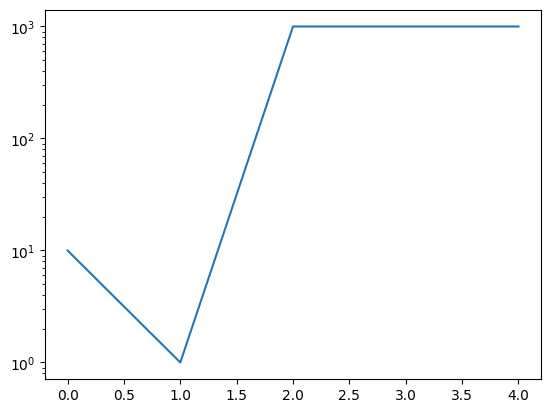

In [197]:
plt.plot(range(5), best_cs)
plt.yscale('log')

**Ответ:** Кажется что ни лучшего коэффициента, ни какой-то закономерности тут нет. От рандома все таки очень много зависит.

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ На этот вопрос можно посмотреть с двух сторон. С одной важна точность,, потому что нам не хочется терять деньги на бесполезных звонках. С другой стороны каждый полезный звонок нам приносит достаточно много денег, поэтому, возможно, стоим максимизировать recall, чтобы найти всех положительных клиентов. 

С моей точно зрения важнее все таки recall.




> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [237]:
def calc_revenue_and_calls(x_train, x_test, y_train, y_test, random, C, threshold) -> list[float]:
    numeric_features = x_train.select_dtypes([np.number]).columns
    categorical = list(x_train.dtypes[x_train.dtypes == "object"].index)

    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
        ('scaling', StandardScaler(), numeric_features)
    ])

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LogisticRegression(C=C, max_iter=1000))
    ])

    model = pipeline.fit(x_train, y_train)
    y_proba = model.predict_proba(x_test)[:, 1]
    y_pred = (y_proba > threshold).astype(int)

    calls = np.sum(y_pred)
    if random:
        revenue = np.sum((y_buyers := y_pred[y_test == 1]) * np.random.uniform(0, 20, len(y_buyers)))
    else:
        revenue = np.sum((y_buyers := y_pred[y_test == 1]) * 10)

    return revenue, calls

def calc_rev_calls_income_std(kf, random: bool, *, C: float = 1, threshold: float = 0.5) -> list[float]:
    revenues = []
    num_of_calls = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        revenue, calls = calc_revenue_and_calls(X_train, X_test, y_train, y_test, random, C, threshold=threshold)
        revenues.append(revenue)
        num_of_calls.append(calls)

    mean_income = np.mean(revenues) - np.mean(num_of_calls)
    incomes = np.array(revenues) - np.array(num_of_calls)
    income_std = sum([(income - mean_income) ** 2 for income in incomes]) / len(incomes)

    return revenues, num_of_calls, income_std

In [262]:
thresholds = np.linspace(0, 1, 100)
scores = dict()
mean_incomes = []
stds = []
for threshold in thresholds:
    mean_income, income_std = calc_mean_income_and_std(kf, C, threshold)
    mean_incomes.append(mean_income)
    stds.append(income_std)
    scores[mean_income] = threshold

best_threshold = next(iter({v: k for k, v in sorted(scores.items(), key=lambda item: item[0], reverse=True)}))


In [263]:
best_threshold

0.12121212121212122

In [264]:
revenues, num_of_calls, income_std = calc_rev_calls_income_std(kf, True, threshold=best_threshold)

print(f'В среднем заработаем: {np.mean(revenues)} баксов')
print(f'при этом придется отдать сотрудникам {np.mean(num_of_calls)} баксов')
print(f'стандартное отклонение выручки от стреднего равно {"{:.2f}".format(np.sqrt(income_std))}')

В среднем заработаем: 5808.611520890861 баксов
при этом придется отдать сотрудникам 1623.6 баксов
стандартное отклонение выручки от стреднего равно 209.93


Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.




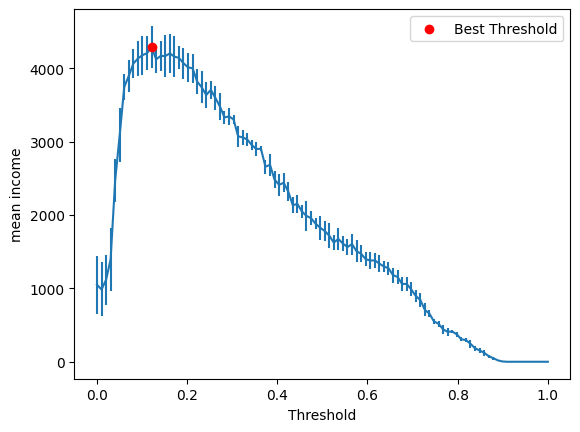

In [265]:
# второй запуск
best_threshold_index = np.argmax(mean_incomes)
best_threshold = thresholds[best_threshold_index]
best_profit = mean_incomes[best_threshold_index]

plt.errorbar(x=thresholds, y=mean_incomes, yerr=np.sqrt(stds))
plt.scatter(best_threshold, best_profit, color='red', label='Best Threshold', zorder=5)
plt.ylabel('mean income')
plt.xlabel('Threshold')
plt.legend()
plt.show()

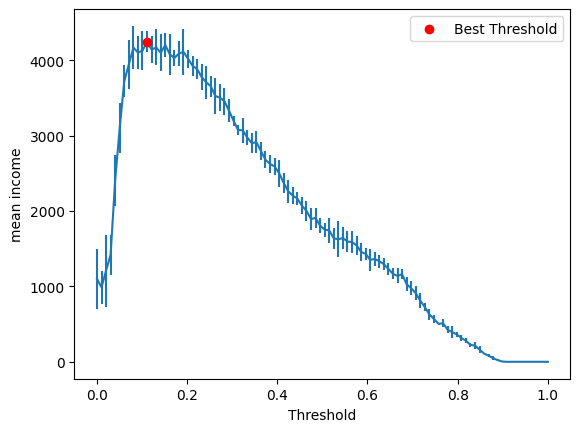

In [257]:
# первый запуск
best_threshold_index = np.argmax(mean_incomes)
best_threshold = thresholds[best_threshold_index]
best_profit = mean_incomes[best_threshold_index]

plt.errorbar(x=thresholds, y=mean_incomes, yerr=np.sqrt(stds))
plt.scatter(best_threshold, best_profit, color='red', label='Best Threshold', zorder=5)
plt.ylabel('mean income')
plt.xlabel('Threshold')
plt.legend()
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ порог получается где-то в районе 0.1. Это подтверждает мою гипотезу о то, что оптимизировать recall важнее.

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [254]:
def train_and_get_pr_rc(x_train: pd.DataFrame, x_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame, *, threshold: float = 0.5, C: int = 1) -> LogisticRegression:
    numeric_features = x_train.select_dtypes([np.number]).columns
    categorical = list(x_train.dtypes[x_train.dtypes == "object"].index)

    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
        ('scaling', StandardScaler(), numeric_features)
    ])

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LogisticRegression(C=C, max_iter=3000))
    ])

    model = pipeline.fit(x_train, y_train)
    y_proba = model.predict_proba(x_test)[:,1]
    binary_predictions = (y_proba > threshold).astype(int)


    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)

    return recall, precision
    

In [255]:
precisions = []
recalls = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    recall, precision = train_and_get_pr_rc(X_train, X_test, y_train, y_test, threshold=best_threshold)
    
    precisions.append(precision)
    recalls.append(recall)

mean_pr = np.mean(precisions)
mean_rc = np.mean(recalls)

print(f'precision = {mean_pr}')
print(f'recall = {mean_rc}')

pr_std = np.sqrt(np.mean((np.array(precisions) - mean_pr) ** 2))
rc_std = np.sqrt(np.mean((np.array(recalls) - mean_rc) ** 2))

print(f'pr_std = {pr_std}')
print(f'rc_std = {rc_std}')

precision = 0.3385818302644577
recall = 0.6390341034361027
pr_std = 0.012624398684627777
rc_std = 0.021337087835820848


Можно пронаблюдать, что наша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом:
- выберите только те пороги, на которых достигается необходимый recall,
- затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат,
- посчитайте площадь под отсеченной кривой

In [269]:
def get_pr_auc_from_high_recall_zone(X_train, X_test, y_train, y_test, C: float = 1) -> float:
    numeric_features = X_train.select_dtypes([np.number]).columns
    categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)

    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
        ('scaling', StandardScaler(), numeric_features)
    ])

    pipeline = Pipeline(steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', LogisticRegression(C=C, max_iter=3000))
    ])

    model = pipeline.fit(X_train, y_train)

    proba_predictions = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, proba_predictions)
    pr_auc = auc(recall[recall >= 0.5], precision[recall >= 0.5])

    return pr_auc

In [270]:
pr_aucs = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pr_auc = get_pr_auc_from_high_recall_zone(X_train, X_test, y_train, y_test)
    
    pr_aucs.append(precision)

mean_pr_auc = np.mean(pr_aucs)

In [271]:
mean_pr_auc

0.3594922100403924

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ 3 вареных яйца и холодец с хреном :-)